In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Installing necessary packages

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.3 MB/s 
     |████████████████████████████████| 6.6 MB 25.2 MB/s 
     |████████████████████████████████| 120 kB 73.3 MB/s 


In [ ]:
! pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.9 MB/s 


In [ ]:
! pip install sentence-splitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.7 MB/s 


In [ ]:
pip install -r rouge/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rouge/requirements.txt'


In [ ]:
pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=dc6e132f31bc4f519ae40db758b163b31954781e2f664bab41e3448dec71fe17
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 8.1 MB/s 


In [ ]:
! pip install git+https://github.com/PrithivirajDamodaran/Parrot.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PrithivirajDamodaran/Parrot.git to /tmp/pip-req-build-lny83ejs
  Running command git clone -q https://github.com/PrithivirajDamodaran/Parrot.git /tmp/pip-req-build-lny83ejs
     |████████████████████████████████| 50 kB 4.2 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
  Created wheel for parrot: filename=parrot-1.0-py3-none-any.whl size=8602 sha256=9d2953283db8e1a78bd449ac849d90126fb646bc4d874eee6d227181844156cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-92d5r3f2/wheels/d8/27/d8/b757755a5b0b804c59714fdd8a4e2733c20802f638f17f7d96
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=75c27afc9ce4012e2014012f1e556bf8df08985f13162b95f885f37f0e27a2dc
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
  Created wheel for 

# Importing libraries

In [ ]:
import pandas as pd
import torch
import csv
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from parrot import Parrot
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")
import json
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Working with the JSON file

In [ ]:
lines = []
for line in open('/content/gdrive/My Drive/Colab Notebooks/nfh_train.json', 'r'):
    lines.append(json.loads(line))

# Data: [https://github.com/yanaiela/num_fh/blob/master/data/resolution/processed/nfh_train.jsonl]

In [ ]:
dict = {}
for i in lines:
  #print(i['head'][0])
  head = i['head'][0]
  sentence = TreebankWordDetokenizer().detokenize(i['tokens'])
  dict[sentence] = head

df = pd.DataFrame.from_dict(dict, orient="index").reset_index()
df.columns = [ 'Text', 'Head']
print(df.head(10))
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_with_head.csv', sep="\t", index = False)

                                                Text      Head
0  What the fuck are you doing? Fifteen! That boy...       AGE
1  I'm telling you, Coach, the guy had to go 290 ...     OTHER
2                   Mama, we are not living in 1215.      YEAR
3  Hovis! My important hat! And w hat hat would t...         4
4  So, how long was it? I counted ten seconds . T...     OTHER
5  However, we don't have to share any cell . If ...        87
6  I still have one bullet left . It's your choic...         4
7  So, first she tells Quinn that she can fix her...  CURRENCY
8  " Isn't Scott Harbin an inelegant creature? A ...        57
9  Now we come to step three . This...drives...mo...     OTHER


# Load the created dataset

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_with_head.csv', sep='\t')

In [ ]:
data

,Text,Head
0,What the fuck are you doing? Fifteen! That boy...,AGE
1,"I'm telling you, Coach, the guy had to go 290 ...",OTHER
2,"Mama, we are not living in 1215.",YEAR
3,Hovis! My important hat! And w hat hat would t...,4
4,"So, how long was it? I counted ten seconds . T...",OTHER
...,...,...
6690,"So, wanna have sex? You tried that one yesterd...",OTHER
6691,No one to talk with all by myself./No one to w...,OTHER
6692,"Wow, honey, look, this place looks spotless! T...",PEOPLE
6693,"Alison: Nine times out of ten, on the street, ...",3


In [ ]:
print(data.Head.unique().tolist()) #  What I am considering: ['AGE', 'OTHER', 'YEAR', 'CURRENCY', 'PEOPLE', 'TIME']

['AGE', 'OTHER', 'YEAR', '4', '87', 'CURRENCY', '57', '68', '46', '3', '12', '76', '19', 'PEOPLE', 'TIME', '65', '132', '78', '189', '5', '34', '10', '21', '140', '157', '13', '23', '55', '17', '70', '56', '20', '48', '8', '11', '18', '89', '67', '14', '152', '30', '131', '45', '7', '2', '43', '39', '22', '25', '24', '51', '27', '16', '472', '61', '198', '6', '103', '1', '9', '155', '35', '97', '72', '42', '77', '69', '15', '36', '31', '229', '28', '84', '38', '50', '99', '71', '292', '44', '83', '125', '291', '112', '41', '64', '29', '32', '33', '49', '40', '0', '127', '79', '74', '26', '101', '94', '118', '66', '196', '52', '238', '37', '123', '145', '142', '73', '106', '53', '232', '114', '226', '54', '102', '194', '90', '184', '179', '156', '137', '141', '88', '247', '193', '116', '47', '63', '178', '294', '144', '134', '104', '91', '86', '138', '96', '109', '160', '139', '58', '85', '59', '771', '98', '130', '335', '62', '262', '265', '80', '136', '224', '81', '108', '170', '148',

# Generate paraphrases using BART

In [ ]:
model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')

In [ ]:
data.head(10)

,Text,Head
0,What the fuck are you doing? Fifteen! That boy...,AGE
1,"I'm telling you, Coach, the guy had to go 290 ...",OTHER
2,"Mama, we are not living in 1215.",YEAR
3,Hovis! My important hat! And w hat hat would t...,4
4,"So, how long was it? I counted ten seconds . T...",OTHER
5,"However, we don't have to share any cell . If ...",87
6,I still have one bullet left . It's your choic...,4
7,"So, first she tells Quinn that she can fix her...",CURRENCY
8,""" Isn't Scott Harbin an inelegant creature? A ...",57
9,Now we come to step three . This...drives...mo...,OTHER


In [ ]:
list_paraphrases = []
for index, row in data[0:50].iterrows():
    batch = tokenizer(row['Text'], return_tensors='pt')
    batch = batch.to('cuda')
    generated_ids = model.generate(batch['input_ids'])
    generated_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    list_paraphrases.append((row['Text'], row['Head'], generated_sentence))

In [ ]:
header = ['Text', 'Head', 'BART']
with open('/content/gdrive/My Drive/Colab Notebooks/generation3.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  for i in list_paraphrases:
    writer.writerow(i)

In [ ]:
generated_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/generation3.csv')

In [ ]:
data2 = generated_data

In [ ]:
data2.head(10)

,Text,Head,BART
0,What the fuck are you doing? Fifteen! That boy...,AGE,['What the fuck are you doing? Fifteen! That b...
1,"I'm telling you, Coach, the guy had to go 290 ...",OTHER,"[""I'm telling you, Coach, the guy had to go 29..."
2,"Mama, we are not living in 1215.",YEAR,"['Mama, we are not living in 1215.']"
3,Hovis! My important hat! And w hat hat would t...,4,['Hovis! My important hat! And w hat hat would...
4,"So, how long was it? I counted ten seconds . T...",OTHER,['How long was it? I counted ten seconds. It w...
5,"However, we don't have to share any cell . If ...",87,"[""However, we don't have to share any cell. If..."
6,I still have one bullet left . It's your choic...,4,"[""I still have one bullet left. It's your choi..."
7,"So, first she tells Quinn that she can fix her...",CURRENCY,"['So, first she tells Quinn that she can fix h..."
8,""" Isn't Scott Harbin an inelegant creature? A ...",57,['Is Scott Harbin an inelegant creature? A mon...
9,Now we come to step three . This...drives...mo...,OTHER,['Now we come to step three. This...drives...m...


# Taking scores

In [ ]:
def get_bleu_score(x, y):
  return sentence_bleu(x,y)

data2['Bleu_BART'] =  generated_data.apply(lambda x: get_bleu_score(x['Text'], x['BART']) if x['BART'] != None  else print("Not available"), axis=1)


In [ ]:
data2.head(10)

,Text,Head,BART,Bleu_BART
0,What the fuck are you doing? Fifteen! That boy...,AGE,['What the fuck are you doing? Fifteen! That b...,1.408377e-231
1,"I'm telling you, Coach, the guy had to go 290 ...",OTHER,"[""I'm telling you, Coach, the guy had to go 29...",1.413452e-231
2,"Mama, we are not living in 1215.",YEAR,"['Mama, we are not living in 1215.']",1.552820e-231
3,Hovis! My important hat! And w hat hat would t...,4,['Hovis! My important hat! And w hat hat would...,1.437021e-231
4,"So, how long was it? I counted ten seconds . T...",OTHER,['How long was it? I counted ten seconds. It w...,1.357913e-231
5,"However, we don't have to share any cell . If ...",87,"[""However, we don't have to share any cell. If...",1.369642e-231
6,I still have one bullet left . It's your choic...,4,"[""I still have one bullet left. It's your choi...",1.370237e-231
7,"So, first she tells Quinn that she can fix her...",CURRENCY,"['So, first she tells Quinn that she can fix h...",1.307207e-231
8,""" Isn't Scott Harbin an inelegant creature? A ...",57,['Is Scott Harbin an inelegant creature? A mon...,1.389142e-231
9,Now we come to step three . This...drives...mo...,OTHER,['Now we come to step three. This...drives...m...,1.353165e-231


In [ ]:
data2.to_csv('/content/gdrive/My Drive/Colab Notebooks/generated_data3.csv', sep="\t", index=False)

In [ ]:
# Corpus BLEU Score:
#[https://machinelearningmastery.com/calculate-bleu-score-for-text-python/]

In [ ]:
def get_bleu_score(list):
  scores = {}
  for i in list:
    print(i)
    sentences = []
    gen_sentences = []
    for index, row in data2.iterrows():
        if row['Head'] == i:
          #print('i2', i)
          sentences.append(row['Text'])
          gen_sentences.append(row['BART'])
    score= corpus_bleu(sentences, gen_sentences)
    print(score)
    scores['score for {}'.format(i)] = score
  return(scores)

In [ ]:
get_bleu_score(['AGE', 'OTHER', 'YEAR', 'CURRENCY', 'PEOPLE', 'TIME'])

AGE
1.396075237825507e-231
OTHER
1.3597825119337098e-231
YEAR
1.4024260093249247e-231
CURRENCY
1.3502395889799505e-231
PEOPLE
1.384292958842266e-231
TIME
1.4005952644970372e-231


{'score for AGE': 1.396075237825507e-231,
 'score for OTHER': 1.3597825119337098e-231,
 'score for YEAR': 1.4024260093249247e-231,
 'score for CURRENCY': 1.3502395889799505e-231,
 'score for PEOPLE': 1.384292958842266e-231,
 'score for TIME': 1.4005952644970372e-231}

# Taking a sample for manual analysis

In [ ]:
data_sampled = data2.sample(n = 50)

In [ ]:
data2.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_sampled_with_head.csv', sep="\t", index=False)

# Bar chart

In [ ]:
Dict = {'score for AGE': 1.396075237825507e-231,
 'score for OTHER': 1.3597825119337098e-231,
 'score for YEAR': 1.4024260093249247e-231,
 'score for CURRENCY': 1.3502395889799505e-231,
 'score for PEOPLE': 1.384292958842266e-231,
 'score for TIME': 1.4005952644970372e-231}

In [ ]:
{k: v for k, v in sorted(Dict.items(), key=lambda item: item[1])}

{'score for CURRENCY': 1.3502395889799505e-231,
 'score for OTHER': 1.3597825119337098e-231,
 'score for PEOPLE': 1.384292958842266e-231,
 'score for AGE': 1.396075237825507e-231,
 'score for TIME': 1.4005952644970372e-231,
 'score for YEAR': 1.4024260093249247e-231}

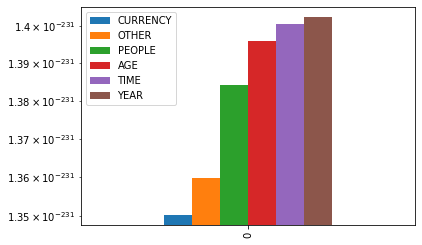

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


df = pd.DataFrame([[1.3502395889799505e-231, 1.3597825119337098e-231, 1.384292958842266e-231, 1.396075237825507e-231, 1.4005952644970372e-231, 1.4024260093249247e-231]], columns= ['CURRENCY', 'OTHER', 'PEOPLE', 'AGE', 'TIME', 'YEAR'])
df.plot.bar()
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.savefig('pic1.png',dpi=400)
plt.show()
